# Análisis con Series de tiempo: Energia solar en Colombia

Este notebook realiza un análisis completo de modelos de series Usando promedios móviles.

## Objetivos:
1. Entender la estructura y calidad de los datos una vez procesados en la etapa de procesamiento
2. Entendimiento de la serie de tiempo
3. Identificar la distribucción de los datos en serie de tiempo
4. Modelado
4.1 Suavización exponencial simple
4.2 Suavización exponencial Lineal (Holt)
4.3 Suavización exzponencial Lineal de Wilters (Holt-Winters)
4.4 Comparación de mdelos


In [2]:
import numpy as np
import pandas as pd  # Operaciones con dataframes
from matplotlib import pyplot as plt  # gráficos
from statsmodels.tsa.seasonal import seasonal_decompose  # descomposición de series
from statsmodels.tsa.holtwinters import SimpleExpSmoothing  # Holwinters simple
# Holwinters doble y tripe
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from sklearn.metrics import mean_squared_error

# 1. Cargar y entender estructura de datos preprocesados

Nuestra primera tarea será leer el archivo csv preprocesado en la primera etapa. Para eso podemos emplear el paquete Pandas. Carguemos los datos en un objeto que denominaremos data.

In [3]:
# Importar funciones del notebook de utilidades
# Usamos %run para ejecutar el notebook completo y tener acceso a todas las funciones
%run ../utils/funcions.ipynb

# Verificar que la función está disponible
print("✓ Funciones importadas correctamente")

✓ Funciones importadas correctamente


In [4]:
# Carga de datos
# El archivo usa punto y coma como separador y coma como decimal
file_path = '../data/results/capacidad_acumulada_processed.csv'


df = load_capacidad_csv_data(file_path, sep=',', decimal='.')
df.head()


,Fecha,SOLAR,EOLICA,PCH
0,2019-01-31,42.539465,0.0,0.7
1,2019-02-28,42.539465,0.0,0.7
2,2019-03-31,42.539465,0.0,0.7
3,2019-04-30,42.539465,0.0,0.7
4,2019-05-31,43.595340,0.0,0.7


In [5]:
df.tail()

,Fecha,SOLAR,EOLICA,PCH
77,2025-06-30,2905.793884,41.0,20.615945
78,2025-07-31,2907.402217,41.0,20.615945
79,2025-08-31,2909.382217,41.0,20.615945
80,2025-09-30,2909.382217,41.0,20.615945
81,2025-10-31,2909.382217,41.0,20.615945


In [6]:
# seleccionando las columnas de interes
df = df[['Fecha', 'SOLAR']]
df['Fecha'] = pd.to_datetime(df['Fecha'], errors='coerce')
df['SOLAR'] = df['SOLAR'].astype(str).str.replace(',', '.').astype(float)
df = df.sort_values('Fecha')
df = df.set_index('Fecha')
df.head()

,SOLAR
Fecha,
2019-01-31,42.539465
2019-02-28,42.539465
2019-03-31,42.539465
2019-04-30,42.539465
2019-05-31,43.595340


Con los datos cargados, procedemos a graficar las métricas de energia SOLAR

## **2. Encontrando los componentes de la serie de tiempo**


Empezamos nuestro análisis descomponiendo la serie de tiempo en sus componentes: **tendencia**, **estacionalidad** y **componente puramente aleatorio**.

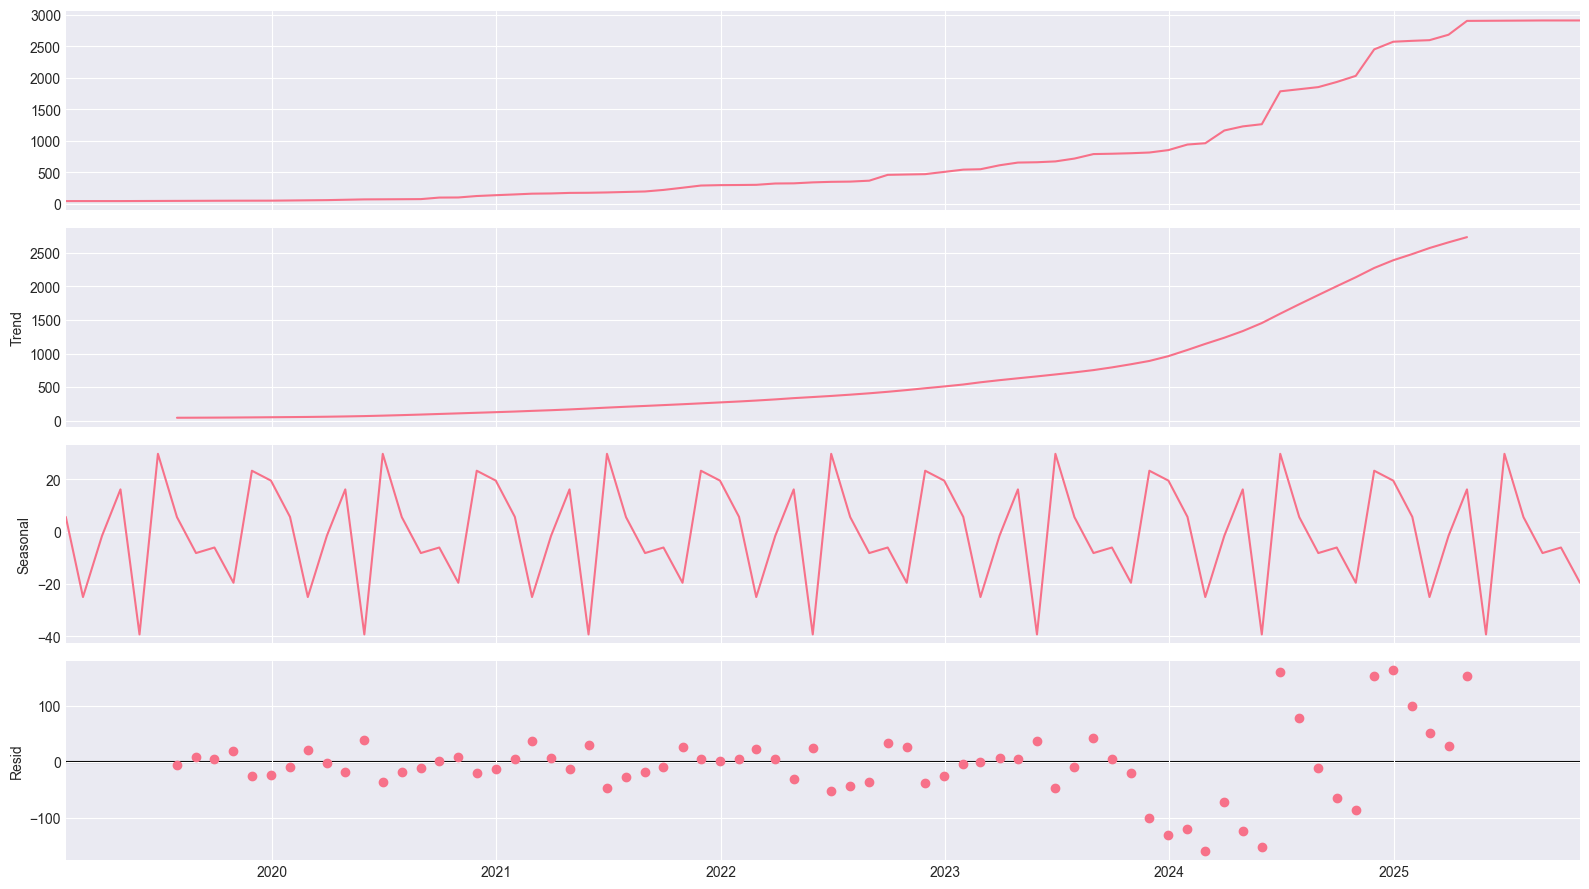

In [7]:
td_componentes = seasonal_decompose(df[["SOLAR"]],model="additive")
fig = td_componentes.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()

Podemos observar el componente estacional marcado en la serie, una tendencia no lineal de los datos y la parte aleatoria.

Es importante mencionar que esta descomposición se emplea solo como referencia para iniciar el análisis.

Antes de entrar a trabajar con los métodos de suavizamiento, vale la pena anotar que una forma sencilla y rápida para quitar el componente estacional (desestacionalizar) es restarle a la serie el componente estacional encontrado en la descomposición. Es decir,

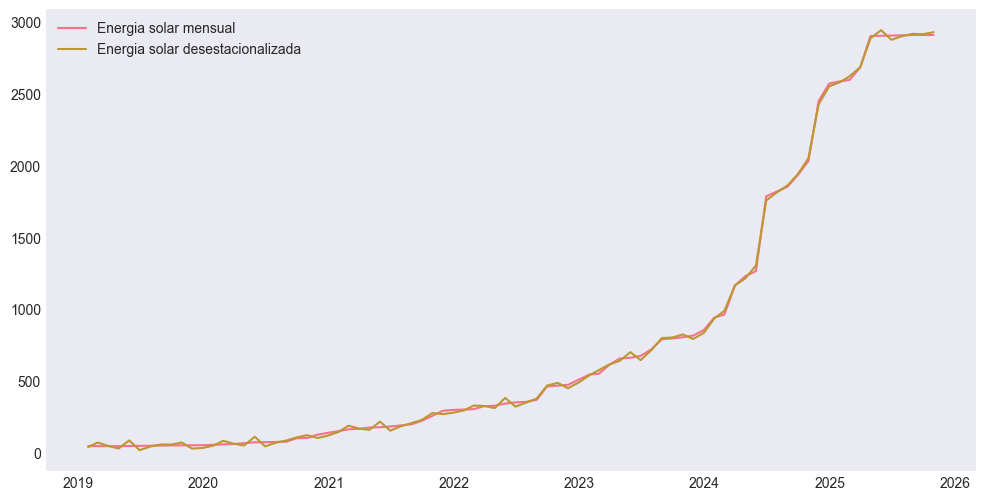

In [8]:
td_desestacionalizada = df["SOLAR"]-td_componentes.seasonal

plt.plot(df["SOLAR"],label="Energia solar mensual")
plt.plot(td_desestacionalizada,label="Energia solar desestacionalizada")
plt.legend()
plt.grid()
plt.show()

# 3. Identificar la distribucción de los datos en serie de tiempo

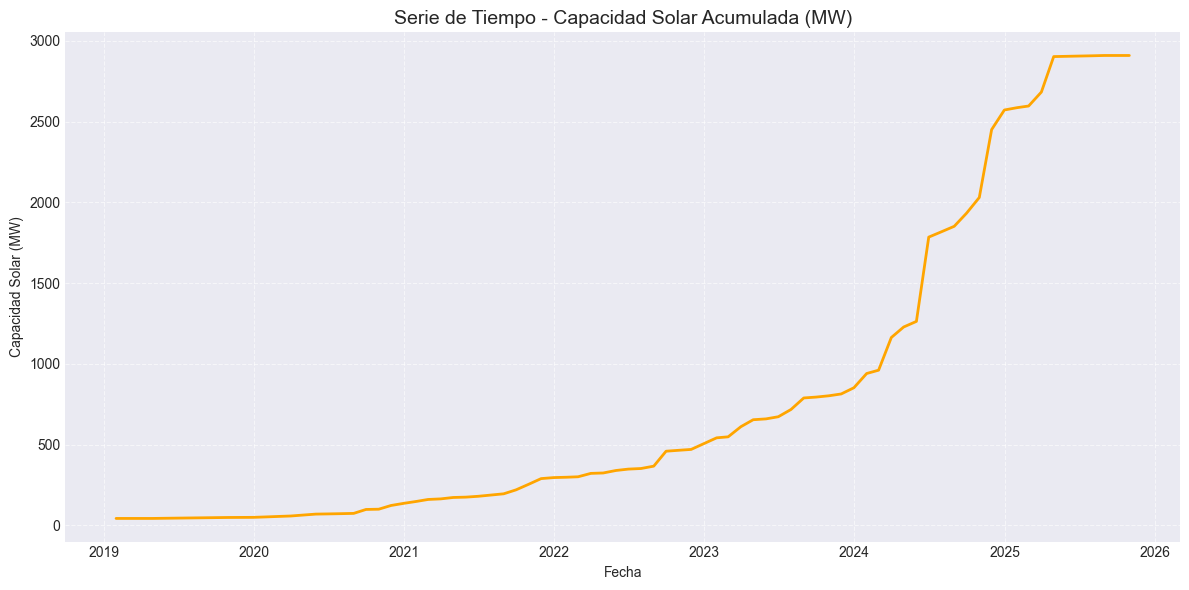

In [9]:
# Graficar la serie de tiempo continua
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['SOLAR'], color='orange', linewidth=2)
plt.title('Serie de Tiempo - Capacidad Solar Acumulada (MW)', fontsize=14)
plt.xlabel('Fecha')
plt.ylabel('Capacidad Solar (MW)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# 4. Modelado con promedios moviles


4.2 Suavización exponencial Lineal (Holt)
4.3 Suavización exzponencial Lineal de Wilters (Holt-Winters)
4.4 Comparación de mdelos

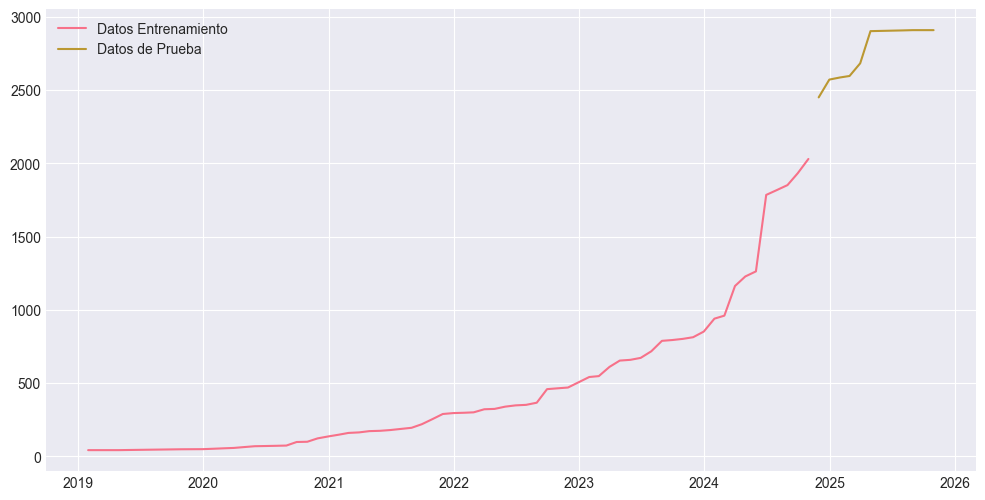

In [10]:
train_len = 70
train_td = df[["SOLAR"]][:train_len]
test_td = df[["SOLAR"]][train_len:]

fig = plt.figure(figsize=(12, 6))
plt.plot(train_td, label="Datos Entrenamiento")
plt.plot(test_td, label="Datos de Prueba")
plt.legend()
plt.show()

In [11]:
## Considerando el dato actual
#  A continuación se calcula el promedio movil para diferentes ventanas, con minimo 2 observaciones
ma_2= train_td.rolling(2,min_periods=2).mean()
ma_3= train_td.rolling(3,min_periods=2).mean()
ma_4= train_td.rolling(4,min_periods=2).mean()
ma_5= train_td.rolling(5,min_periods=2).mean()
ma_6= train_td.rolling(6,min_periods=2).mean()
ma_7= train_td.rolling(7,min_periods=2).mean()

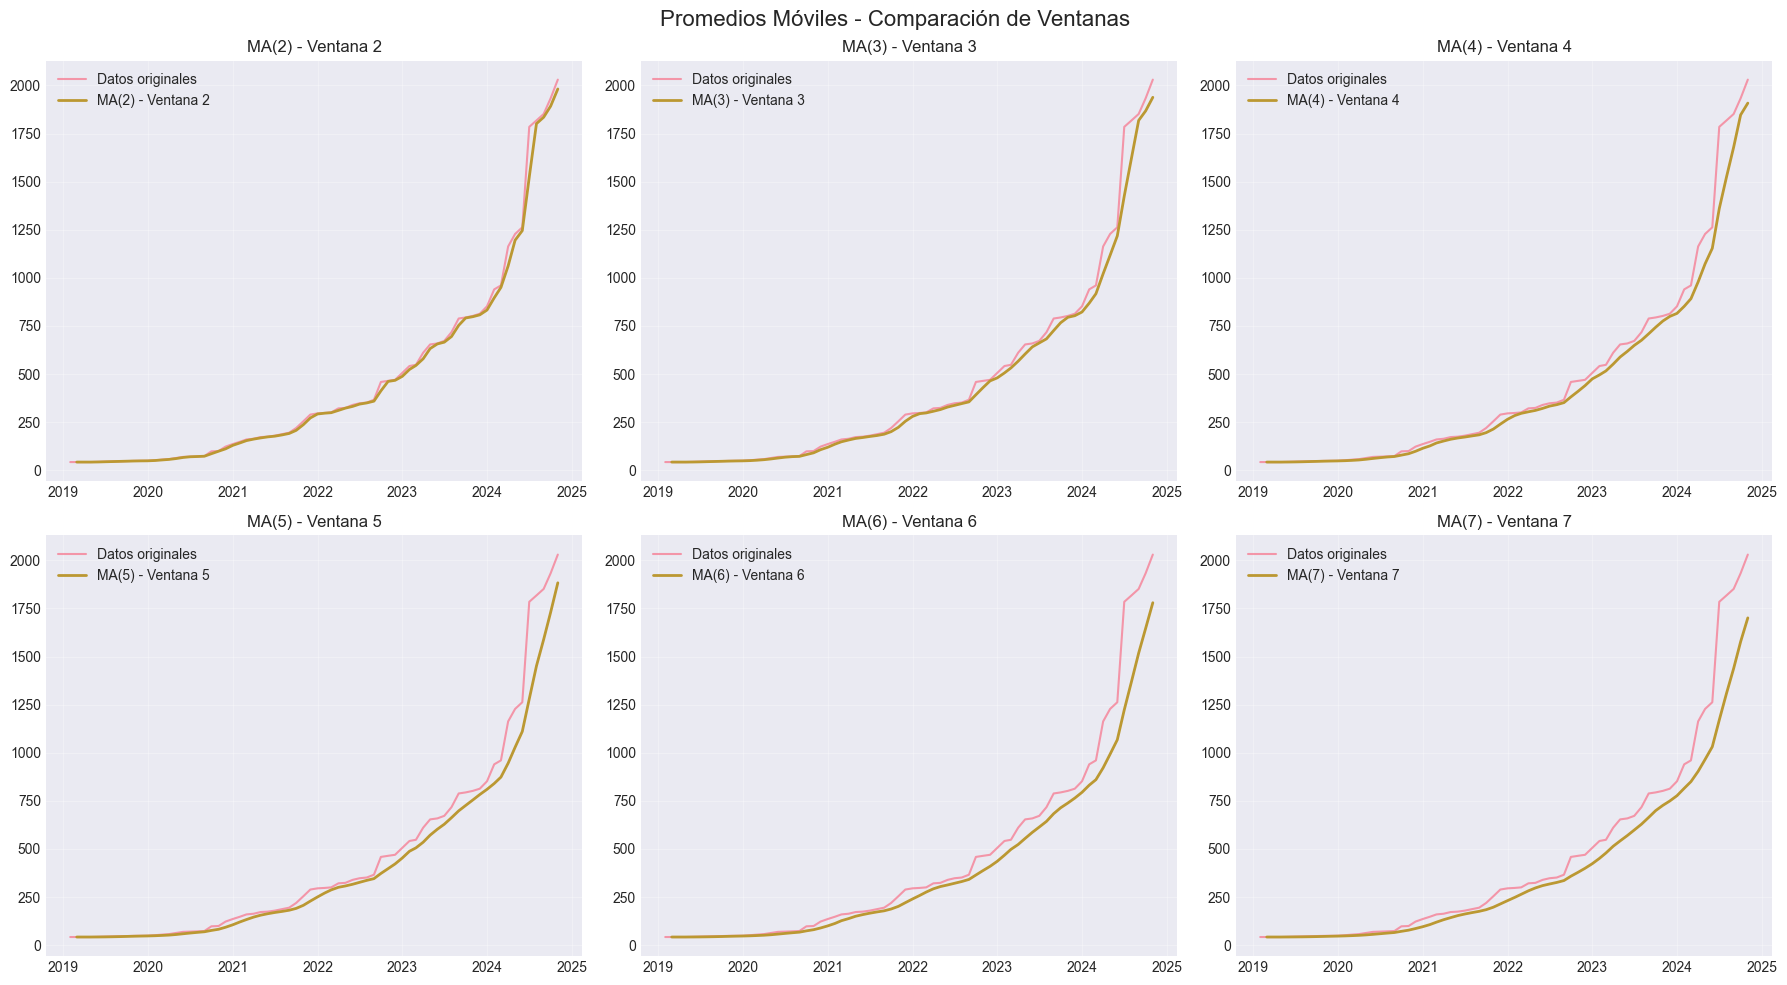

In [12]:
#graficar_promedios_moviles(medias_moviles, train_td)
medias_moviles = [
    (ma_2, 'MA(2) - Ventana 2'),
    (ma_3, 'MA(3) - Ventana 3'),
    (ma_4, 'MA(4) - Ventana 4'),
    (ma_5, 'MA(5) - Ventana 5'),
    (ma_6, 'MA(6) - Ventana 6'),
    (ma_7, 'MA(7) - Ventana 7')
]

graph_moving_averages(medias_moviles, train_td, 'Promedios Móviles - Comparación de Ventanas')

In [13]:
## A continuación se calcula el promedio movil para diferentes ventanas, con minimo 2 observaciones sin considerar el dato actual
ma_2= train_td.shift().rolling(2,min_periods=2).mean()
ma_3= train_td.shift().rolling(3,min_periods=2).mean()
ma_4= train_td.shift().rolling(4,min_periods=2).mean()
ma_5= train_td.shift().rolling(5,min_periods=2).mean()
ma_6= train_td.shift().rolling(6,min_periods=2).mean()
ma_7= train_td.shift().rolling(7,min_periods=2).mean()


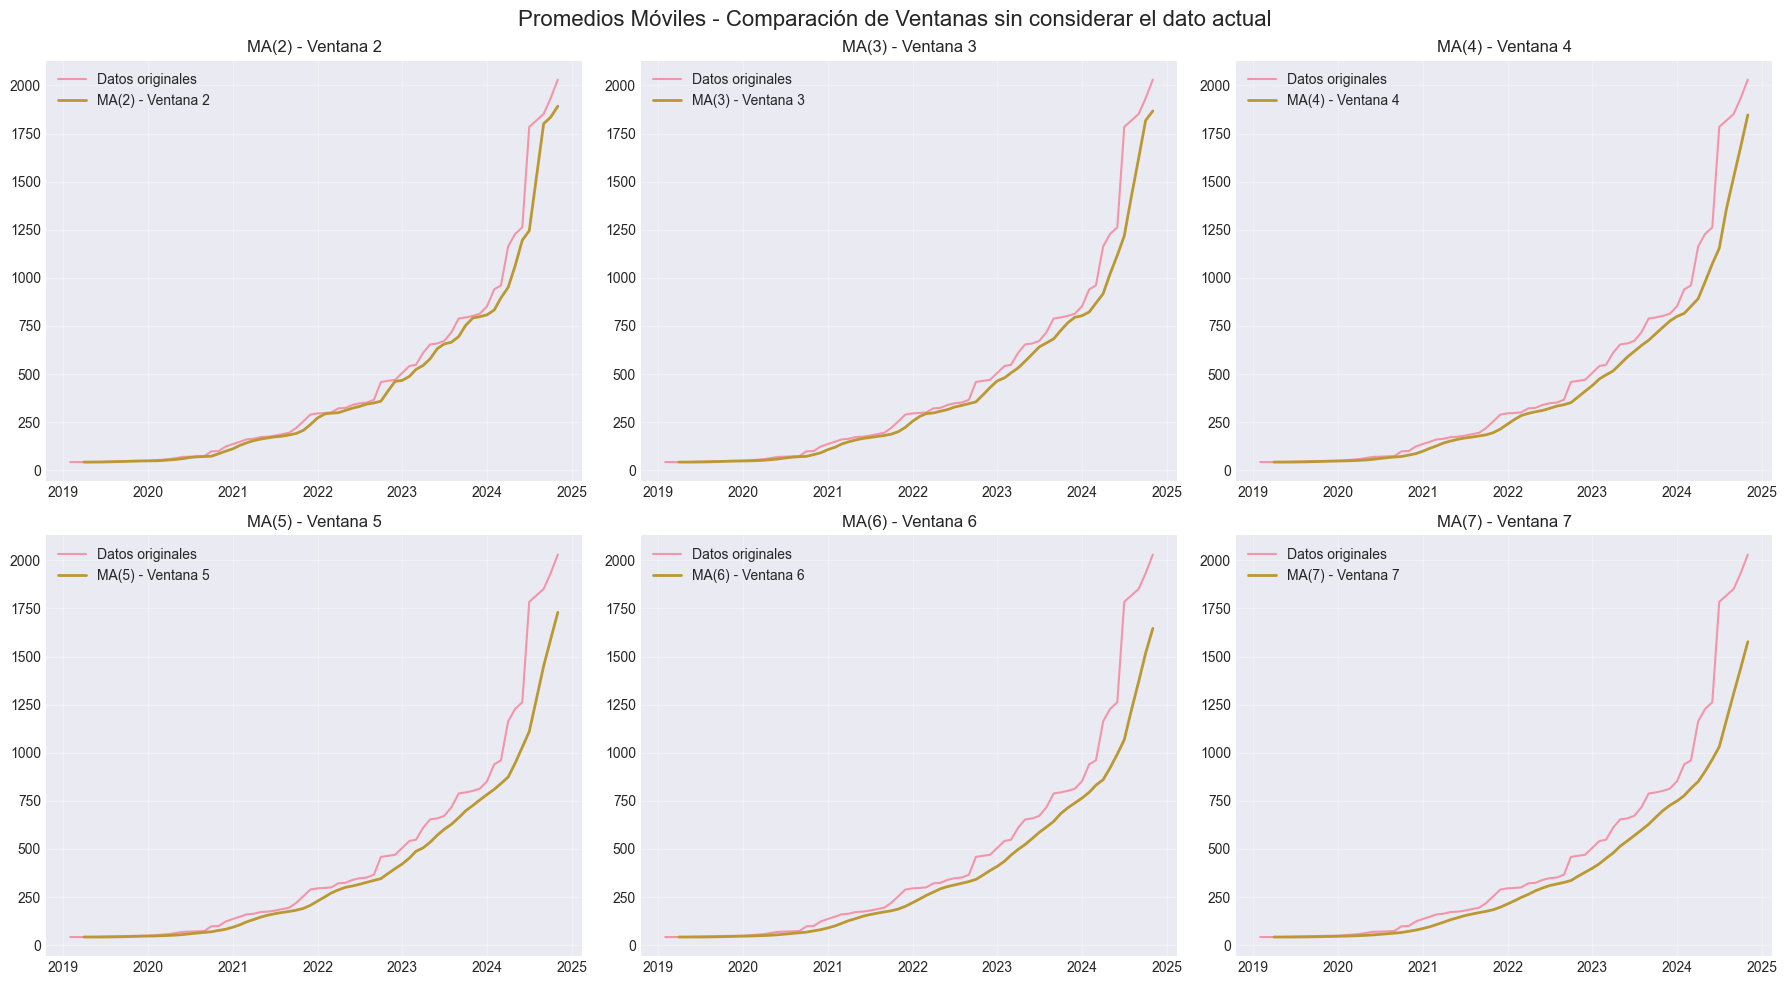

In [14]:
#graficar_promedios_moviles(medias_moviles, train_td)
medias_moviles = [
    (ma_2, 'MA(2) - Ventana 2'),
    (ma_3, 'MA(3) - Ventana 3'),
    (ma_4, 'MA(4) - Ventana 4'),
    (ma_5, 'MA(5) - Ventana 5'),
    (ma_6, 'MA(6) - Ventana 6'),
    (ma_7, 'MA(7) - Ventana 7')
]

graph_moving_averages(medias_moviles, train_td,'Promedios Móviles - Comparación de Ventanas sin considerar el dato actual')

In [18]:
# Función para hacer pronósticos con media móvil
#datos: Serie o DataFrame con índice temporal (se espera índice datetime).
#w: tamaño de la ventana (número de observaciones a promediar).
#h: número de pasos a pronosticar.
def fore_ma(datos,w,h):
  data=datos.copy()
  for x in range(1,h+1):
    ind = data.index[-1]
    value = ind + pd.DateOffset(months=1)
    data.loc[value]= data[-w:].mean()
  return data[-h:]
  
# Se generan 6 pronosticos para cada una de las ventanas de 2 a 7
ma_2_f= fore_ma(train_td,2,12)
ma_3_f= fore_ma(train_td,3,12)
ma_4_f= fore_ma(train_td,4,12)
ma_5_f= fore_ma(train_td,5,12)
ma_6_f= fore_ma(train_td,6,12)
ma_7_f= fore_ma(train_td,7,12)

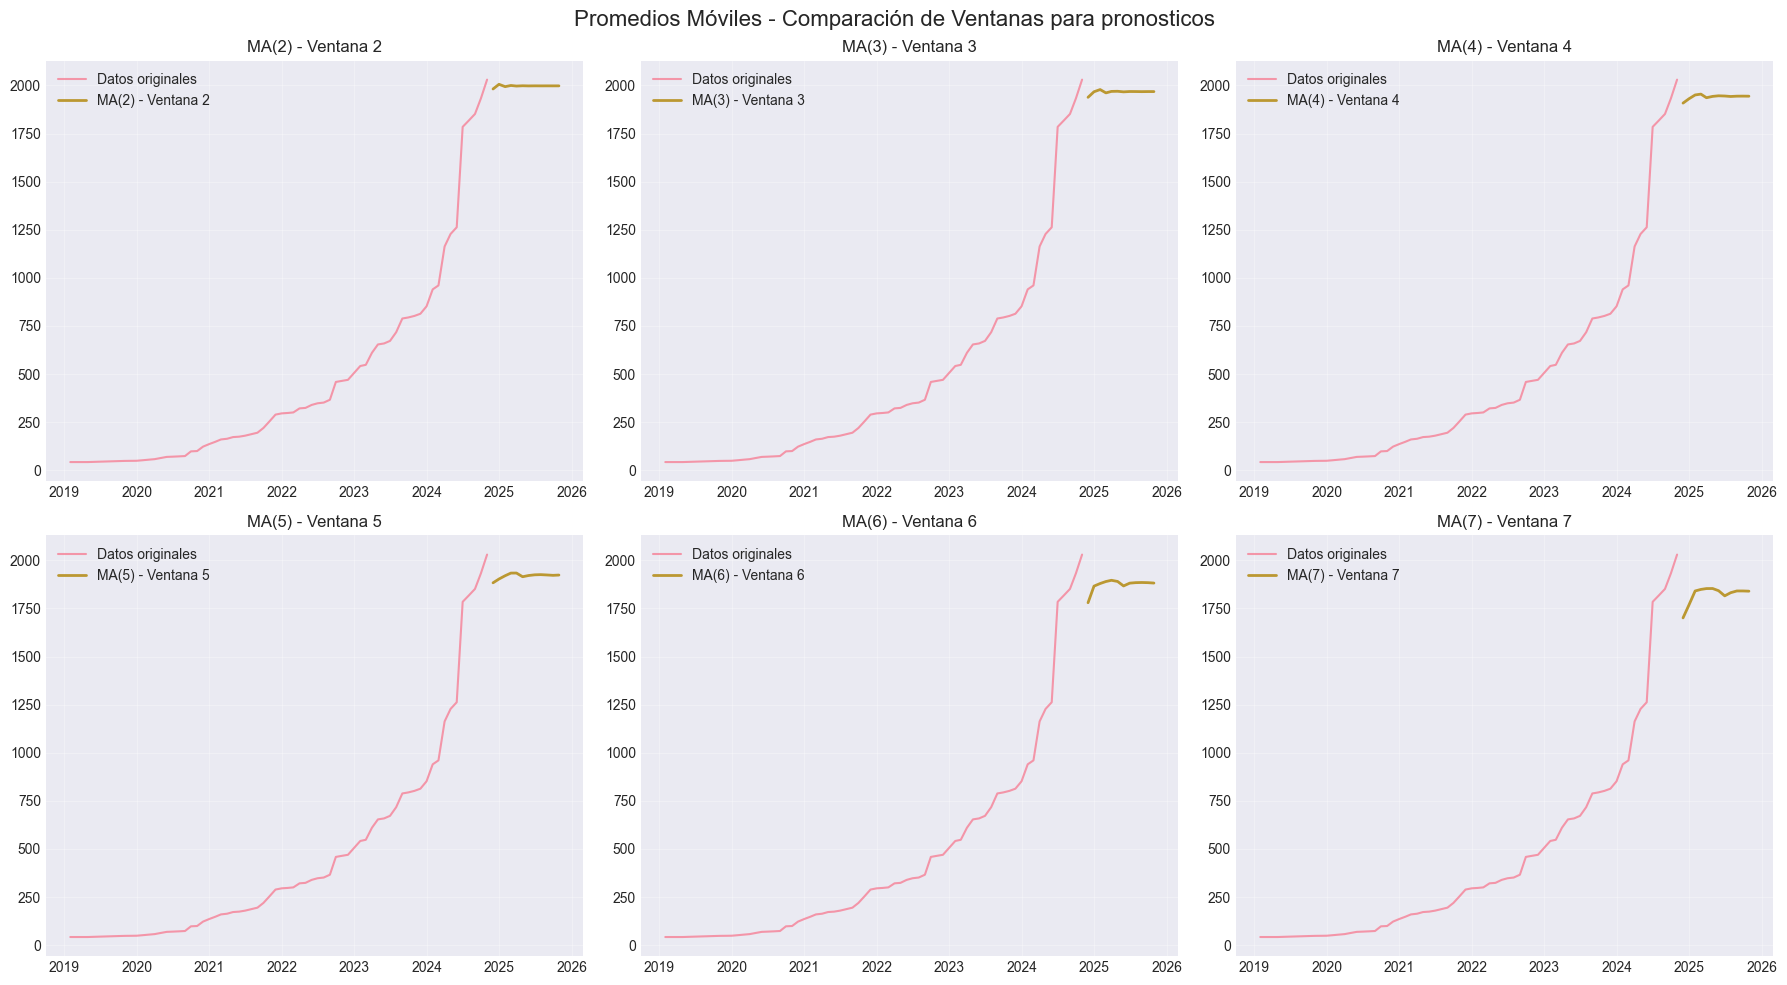

In [19]:
#graficar_promedios_moviles para los pronosticos
medias_moviles = [
    (ma_2_f, 'MA(2) - Ventana 2'),
    (ma_3_f, 'MA(3) - Ventana 3'),
    (ma_4_f, 'MA(4) - Ventana 4'),
    (ma_5_f, 'MA(5) - Ventana 5'),
    (ma_6_f, 'MA(6) - Ventana 6'),
    (ma_7_f, 'MA(7) - Ventana 7')
]

graph_moving_averages(medias_moviles, train_td,'Promedios Móviles - Comparación de Ventanas para pronosticos')

In [20]:
#Calculo de RMSE para cada modelo
# Esta línea calculamos el RMSE (raíz del error cuadrático medio) entre los valores reales de prueba (test_td) y los pronósticos del promedio móvil para cada una de las ventanas
rmse_ma_2 = np.sqrt(mean_squared_error(test_td,ma_2_f ))
rmse_ma_3 = np.sqrt(mean_squared_error(test_td,ma_3_f ))
rmse_ma_4 = np.sqrt(mean_squared_error(test_td,ma_4_f ))
rmse_ma_5 = np.sqrt(mean_squared_error(test_td,ma_5_f ))
rmse_ma_6 = np.sqrt(mean_squared_error(test_td,ma_6_f ))
rmse_ma_7 = np.sqrt(mean_squared_error(test_td,ma_7_f ))

In [21]:
print("RMSE para cada modelo")
print( "rmse_ma_2:", rmse_ma_2)
print( "rmse_ma_3:", rmse_ma_3)
print( "rmse_ma_4:", rmse_ma_4)
print( "rmse_ma_5:", rmse_ma_5)
print( "rmse_ma_6:", rmse_ma_6)
print( "rmse_ma_7:", rmse_ma_7)

RMSE para cada modelo
rmse_ma_2: 790.8036599282899
rmse_ma_3: 820.62994005512
rmse_ma_4: 844.9527205841794
rmse_ma_5: 865.8116109162384
rmse_ma_6: 909.0207437203741
rmse_ma_7: 957.7660618276068


## 5. Pronóticos

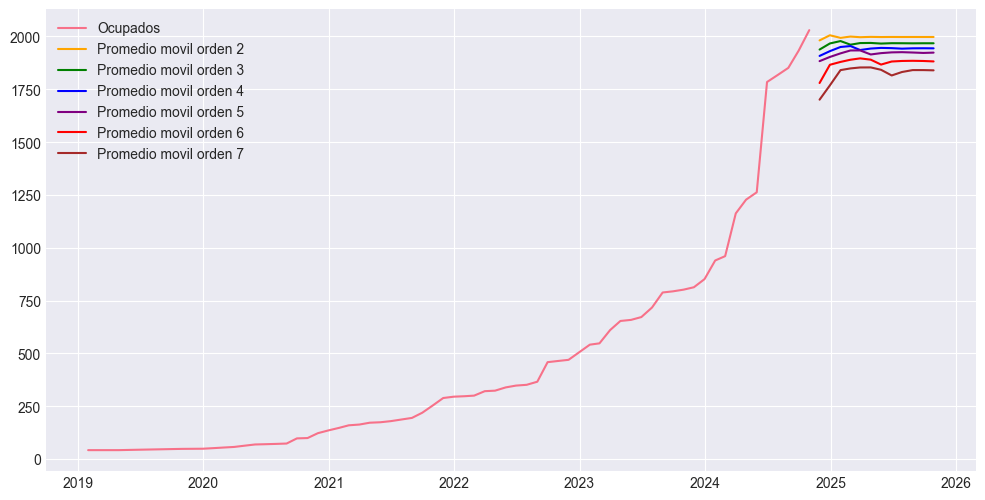

In [23]:
fig = plt.figure(figsize=(12, 6))
plt.plot(train_td,label="Ocupados")
plt.plot(ma_2_f,label="Promedio movil orden 2", color='orange')
plt.plot(ma_3_f,label="Promedio movil orden 3", color='green')
plt.plot(ma_4_f,label="Promedio movil orden 4", color='blue')
plt.plot(ma_5_f,label="Promedio movil orden 5", color='purple')
plt.plot(ma_6_f,label="Promedio movil orden 6", color='red')
plt.plot(ma_7_f,label="Promedio movil orden 7", color='brown')
plt.legend()
plt.show()